In [30]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

from devices import Chadoq2
from sequences import Sequence
from pulses import Pulse
import waveforms

We shall implement a version of Variational Quantum Simulation, following https://arxiv.org/pdf/1810.03421 .

First we set up our atom array

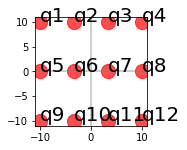

In [411]:
# How many qubits (MxN):
M = 3 #vert
N = 4 #horiz

# Rectangle dimensions to place qubits:
LX = 20
LY = 20

coords = np.array([[j,-i] for i in np.linspace(0,LX,M) for j in np.linspace(0,LY,N)])
coords -= np.mean(coords,axis=0)

qubits = {}
for i, coord in enumerate(coords,1):
    qubits[f"q{i}"] = coord


# Plot atom array:
#print(qubits)
fig, ax = plt.subplots(figsize=(LY/10, LX/10))
ax.scatter(coords[:,0],coords[:,1],s=200,alpha=0.7,c='r')
ax.axvline(0,c='grey',alpha=0.5)
ax.axhline(0,c='grey',alpha=0.5)

for q in qubits:
    ax.annotate(q, (qubits[q][0], qubits[q][1]),fontsize=20)

plt.show()

Next, we select our device and we declare the channels that we will be using

In [412]:
device = Chadoq2(qubits)
seq = Sequence(device) # Resets if called again
pprint(seq.available_channels)

seq.declare_channel('ryd', 'rydberg_global') # We shall be acting on all the atoms
pprint(seq.declared_channels)

{'raman_local': Raman(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns),
 'rydberg_global': Rydberg(global, Max Absolute Detuning: 50 MHz, Max Amplitude: 1.25 MHz),
 'rydberg_local': Rydberg(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns),
 'rydberg_local2': Rydberg(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns)}
{'ryd': Rydberg(global, Max Absolute Detuning: 50 MHz, Max Amplitude: 1.25 MHz)}


Create some waveforms to construct pulses

In [413]:
gaussian = waveforms.GaussianWaveform(1000,4,250) #duration=100, max_ampl=2, stdev=150
ramp = waveforms.RampWaveform(gaussian.duration, -20, 20)  # Duration: 1000ns, linear sweep from -20 to 20 MHz

Create the layers of the circuit as pulse sequences

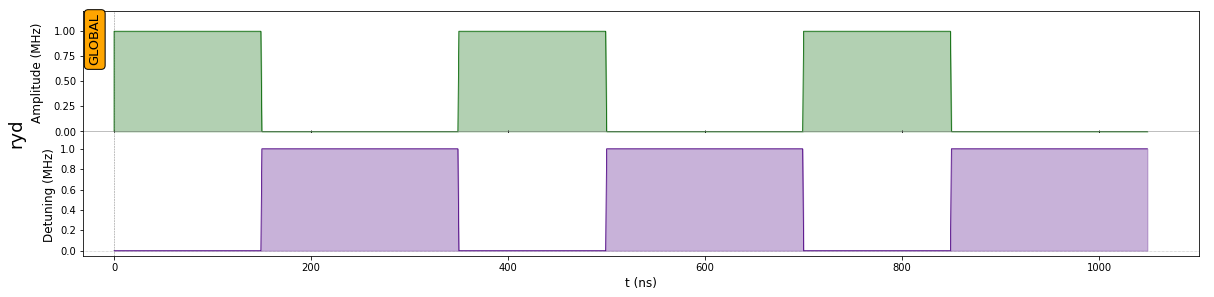

In [414]:
layers = 3

cost = Pulse.ConstantPulse(150, 1, 0, 0)

#seq = Sequence(device) # Resets sequence every time its called
#seq.declare_channel('ryd', 'rydberg_global') # We shall be acting on all the atoms

mix = Pulse.ConstantPulse(200, 0, 1, 0)

for _ in range(layers):
    seq.add(cost, 'ryd')
    seq.add(mix, 'ryd')

seq.draw()

# Emulating a run of the sequence

First we create the Qobjs that represent the Quantum Resource

In [415]:
# Some useful functions:

def get_dist(a,b):
    """
    Returns the distance r_ij between qubits i and j.
    Recall a and b can be strings like 'q4', etc.
    """
    x = qubits[a]
    y = qubits[b]
    return np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2 )

In [416]:
import qutip


# Global variable for generating tensor product of identities
ones = [qutip.qeye(2) for _ in range(N*M)]

#Global dictionary of operators:
gates = {'paulix' : qutip.sigmax(),
         'pauliy' : qutip.sigmay(),
         'pauliz' : qutip.sigmaz(),
         'occup' : 0.5 * (1+qutip.sigmaz()) }

def get_neighbors(qubit_id, N, M):
    """
    returns the labels of the nearest neighbors of a qubit ID, with open boundary conditions
    """
    i = int(qubit_id[1:])
    if i == 1:
        return([f'q2', f'q{N+1}'])
    elif i == N:
        return([f'q{N-1}',f'q{2*N}'])
    elif i == (M-1)*N + 1:
        return([f'q{(M-2)*N+1}',f'q{(M-1)*N+2}'])
    elif i == M*N:
        return([f'q{M*N-1}',f'q{(M-1)*N}'])
    elif i < N:
        return([f'q{i-1}',f'q{i+1}',f'q{N+i}'])
    elif i % N == 1:
        return([f'q{i-N}',f'q{i+N}',f'q{i+1}'])
    elif i % N == 0:
        return([f'q{i-N}',f'q{i+N}',f'q{i-1}'])
    elif i > (M-1)*N + 1:
        return([f'q{i+1}', f'q{i-1}',f'q{i-N}'])
    else:
        return([f'q{i-1}',f'q{i+1}',f'q{i+N}',f'q{i-N}'])

def local_operator(qubit_id,name):
    """
    Returns a local gate at a qubit
    """
    temp = ones.copy()
    pos = int(qubit_id[1:]) - 1 #so that it runs from 0 to N*M-1
    temp[pos] = gates[name]
    return qutip.tensor(temp)

def two_body_operator(qubit_id1, qubit_id2, name):
    """
    Returns a local gate at a qubit
    """
    temp = ones.copy()
    pos1 = int(qubit_id1[1:]) - 1 #so that it runs from 0 to N*M-1
    pos2 = int(qubit_id2[1:]) - 1 #so that it runs from 0 to N*M-1
    temp[pos1] = gates[name]
    temp[pos2] = gates[name]
    return qutip.tensor(temp)

In [417]:
# Sum of sigma x:

H_X = 0 # Time-dependent
for qubit in qubits:
    H_X += local_operator(qubit,'paulix')
    
# Sum of occupations:

H_N = 0 # Time-dependent
for qubit in qubits:
    H_N -= local_operator(qubit,'occup')
    
# Sum of Neighbors:
H_NN = 0 # Time-independent
C6 = 1e5
for qubit in qubits:
    for qubit2 in qubits:
        if qubit != qubit2:
            R = get_dist(qubit,qubit2)
            coupling = C6/R**6
            H_NN += coupling * two_body_operator(qubit,qubit2,'occup')


Now we want to extract the contents of the sequences into the qubits, as instructions for emulation in qutip

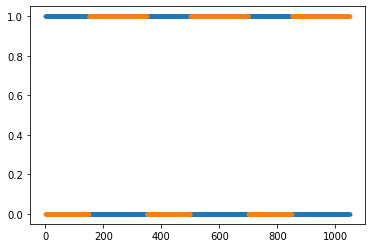

In [419]:
# Get Rabi freq and detuning samples from all sequence

amp = []
det = []
for x in seq._schedule['ryd']:
    obj = x.type
    if type(obj) == Pulse:
        #absolute_time = np.arange(x.ti,x.tf) #absolute time tags from ti to tf of each sequence block
        #print(alsolute_time)
        relative_time = range(obj.duration) # relative time to sequence block
        
        for t in relative_time: 
            amp.append(obj.amplitude.samples[t])
            det.append(obj.detuning.samples[t])

plt.plot(range(1050),amp,'.')
plt.plot(range(1050),det,'.')

In [421]:
observable = local_operator("q10",'pauliz') + two_body_operator('q1','q7','paulix')
psi0 = qutip.tensor([qutip.basis(2, 0) for _ in range(N*M)]) # all up

# Callables for time evolution
def omega (t,args):
    return amp[int(t)]

def delta (t,args): 
    return det[int(t)]


H = [H_NN, [H_N, delta], [H_X, omega]]

output = qutip.sesolve(H, psi0, np.arange(650), [observable])

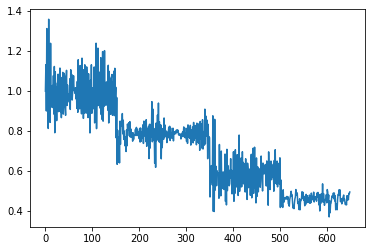

In [422]:
plt.plot(range(650),output.expect[0])

This is an example of solving QAOA using our pulse sequences

In [7]:
def my_funct(x,y):
    return x*np.cosh(x+y)

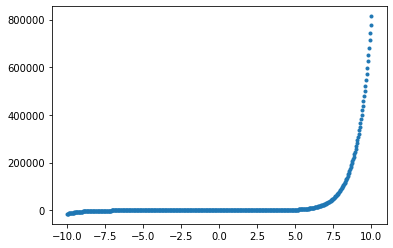

In [8]:
import scipy.optimize
xx = np.linspace(-10,10,500)
plt.plot(xx,my_funct(xx,2),'.')

In [12]:
from program import*

In [17]:
my_device = Chadoq2(qubits)

layers = 5

qaoa = Variational(my_device, QAOA_builder, layers, scipy.optimize.minimize)

Using <class 'program.QAOA_builder'>


In [18]:
# Define first guess
guess = [[345 for _ in range(layers)],[167 for _ in range(layers)]]

qaoa.optimize(guess)

Sequence Builder Activated. Type: QAOA...
parameters are [345. 345. 345. 345. 345.] and [167. 167. 167. 167. 167.]
Sequence Builder Activated. Type: QAOA...
parameters are [345.00000001 345.         345.         345.         345.        ] and [167. 167. 167. 167. 167.]
Sequence Builder Activated. Type: QAOA...
parameters are [345.         345.00000001 345.         345.         345.        ] and [167. 167. 167. 167. 167.]
Sequence Builder Activated. Type: QAOA...
parameters are [345.         345.         345.00000001 345.         345.        ] and [167. 167. 167. 167. 167.]
Sequence Builder Activated. Type: QAOA...
parameters are [345.         345.         345.         345.00000001 345.        ] and [167. 167. 167. 167. 167.]
Sequence Builder Activated. Type: QAOA...
parameters are [345.         345.         345.         345.         345.00000001] and [167. 167. 167. 167. 167.]
Sequence Builder Activated. Type: QAOA...
parameters are [345. 345. 345. 345. 345.] and [167.00000001 167.    